# Social Media Processing

This notebook shows how to use HuggingFace's package to import and train regression models to assess humor rating in social media posts in English (SemEval2021: HaHackathon: Detecting and Rating Humor and Offense https://competitions.codalab.org/competitions/27446, **Task-1b**).

Detection of humour, especially in social media posts, poses a linguistic challenge to NLP, due to the noise, figurative language, contextuality and subjectivity. You will hence try different methods to address those challenges such as preprocessing, data augmentation, ensembling and multi-task learning.

We will download and unzip the data from here: http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip.


We recommend you to do this lab on a Colab GPU provided by Google.

In [1]:
!wget http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
!unzip '/content/hahackathon_data.zip' -x __MACOSX/*

--2025-03-14 17:58:07--  http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
Resolving smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)... 129.215.10.97
Connecting to smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)|129.215.10.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571603 (558K) [application/zip]
Saving to: ‘hahackathon_data.zip’

hahackathon_data.zi 100%[===================>] 558.21K   808KB/s    in 0.7s    

2025-03-14 17:58:08 (808 KB/s) - ‘hahackathon_data.zip’ saved [571603/571603]

Archive:  /content/hahackathon_data.zip
   creating: hahackathon data/
  inflating: hahackathon data/.DS_Store  
  inflating: hahackathon data/test.csv  
  inflating: hahackathon data/dev.csv  
  inflating: hahackathon data/train.csv  


First, we need to install Hugging Face [transformers](https://huggingface.co/transformers/index.html) and [Sentence piece Tokenizers](https://github.com/google/sentencepiece), as well as some helper libraries, with the following commands.

In [2]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q  ipywidgets
!jupyter nbextension enable --py widgetsnbextension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.utils.data import Dataset, DataLoader

We define the fix seed method to be able to introduce variety into ensembling models.

In [4]:
# Set random seed for reproducibility
def set_random_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_random_seed()

## Regression with BERT

We will use the [DistilBert](https://arxiv.org/abs/1910.01108v4) model and its Tokeniser following the preprocessing code from Lab on Aspect-Based Sentiment Analysis.

In [5]:
import tqdm

# Constants
PAD_LENGTH = 128
BATCH_SIZE = 256
EPOCHS = 5
bert_model = 'distilbert-base-uncased'

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(bert_model, do_lower_case=True, max_length=PAD_LENGTH, padding='max_length', truncation=True)

def tokenize(sentences, tokenizer, pad_length=PAD_LENGTH, pad_to_max_length=True):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        return inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids']

    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])
    return input_ids, input_masks, input_segments


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Let's read the data using Pandas.

In [6]:
import pandas as pd

# Load data with only the necessary columns
train_df = pd.read_csv('hahackathon data/train.csv', usecols = ['text','humor_rating','offense_rating'])
dev_df = pd.read_csv('hahackathon data/dev.csv', usecols = ['text','humor_rating','offense_rating'])
test_df = pd.read_csv('hahackathon data/test.csv', usecols = ['text','humor_rating','offense_rating'])

# Drop the Nans
train_df = train_df.dropna()
dev_df = dev_df.dropna()
test_df = test_df.dropna()

Let's check a couple of examples.

In [7]:
train_df

text  humor_rating  \
0     TENNESSEE: We're the best state. Nobody even c...          2.42   
1     A man inserted an advertisement in the classif...          2.50   
2     How many men does it take to open a can of bee...          1.95   
3     Told my mom I hit 1200 Twitter followers. She ...          2.11   
4     Roses are dead. Love is fake. Weddings are bas...          2.78   
...                                                 ...           ...   
7991  Sins are like viruses, it's better you keep th...          2.13   
7993  My daughter wanted a Cinderella themed birthda...          3.70   
7996    Why are aspirins white? Because they work sorry          1.33   
7997  Today, we Americans celebrate our independence...          2.55   
7998  How to keep the flies off the bride at an Ital...          1.00   

      offense_rating  
0               0.20  
1               1.10  
2               2.40  
3               0.00  
4               0.10  
...              ...  
7991            0.10  
7993            0.00  
7996            3.85  
7997            0.00  
7998            3.00  

[4932 rows x 3 columns]

In [8]:
# Get the post text
train_examples_list = train_df['text'].tolist()
dev_examples_list = dev_df['text'].tolist()
test_examples_list = test_df['text'].tolist()

# Get the humour rating for the regression task (we normalise, the values are between 0 and 5)
train_targets_list = (train_df['humor_rating']/5).tolist()
dev_targets_list = (dev_df['humor_rating']/5).tolist()
test_targets_list = (test_df['humor_rating']/5).tolist()

In [9]:
def get_bert_inputs(examples_list, targets):
  input_ids=list()
  attention_masks=list()

  bert_inp=tokenize(examples_list, tokenizer)
  input_ids = bert_inp[0]
  attention_masks = bert_inp[1]

  return input_ids, attention_masks, targets

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
dev_input_ids, dev_attention_masks, dev_targets = get_bert_inputs(dev_examples_list, dev_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


**Task 1: Build a neural bag of words model using DistilBERT embeddings and the sigmoid activation on the output layer for the regression task.**

Investigate its performance using the Mean Squared Error (MSE) metric. We will use this metric as the loss function as well. We will also use the Adam optimiser with `learning_rate=2e-5`. This code is already provided.

*Hint*: You can reuse the code from Lab on Aspect-Based Sentiment Analysis (Model 2).

In [10]:
class GlobalAveragePooling1DMasked(nn.Module):
    def forward(self, x, mask):
        mask = mask.unsqueeze(-1).float()
        x = x * mask
        sum_x = torch.sum(x, dim=1)
        sum_mask = torch.sum(mask, dim=1)
        return sum_x / sum_mask

# Define model
class BERTRegressionModel(nn.Module):

    def __init__(self, pad_length=128):
        super(BERTRegressionModel, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model)
        self.global_avg_pool = GlobalAveragePooling1DMasked()
        self.hidden_layer = nn.Linear(self.bert.config.hidden_size, 16)
        self.activation = nn.Sigmoid()
        self.output_reg = nn.Linear(16, 1)

    def forward(self, input_ids, attention_mask):
        """
        Task 1

        Begin
        """
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Extract the last hidden state from BERT
        last_hidden_states = outputs.last_hidden_state  # shape: [batch_size, seq_length, hidden_size]

        # Apply global average pooling, taking the attention mask into account
        pooled_output = self.global_avg_pool(last_hidden_states, attention_mask)  # shape: [batch_size, hidden_size]

        # Pass the pooled output through a hidden linear layer
        hidden_output = self.hidden_layer(pooled_output)  # shape: [batch_size, 16]

        # Compute the regression output and apply the sigmoid activation
        # (to ensure the output is in the range [0,1], matching our normalized targets)
        reg_output = self.output_reg(hidden_output)  # shape: [batch_size, 1]
        out_reg = self.activation(reg_output)






        """
        End Task 1
        """

        return out_reg


model = BERTRegressionModel()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [11]:
print(model)

BERTRegressionModel(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [12]:
# Dataset Class
class HumorDataset(Dataset):
    def __init__(self, input_ids, attention_masks, targets):
        self.input_ids = torch.tensor(input_ids)
        self.attention_masks = torch.tensor(attention_masks)
        self.targets = torch.tensor(targets)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'target': self.targets[idx].float()
        }

In [13]:
# Training setup
def train_model(model, train_loader, val_loader, device, epochs=EPOCHS, lr=2e-5):
    model.train()
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)
            outputs = model(input_ids, attention_mask)

            loss = loss_fn(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                targets = batch['target'].to(device)
                outputs = model(input_ids, attention_mask)
                loss = loss_fn(outputs.squeeze(), targets)
                val_loss += loss.item()

        print(f"Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")


We evaluate our model on the test set.

In [14]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Prepare DataLoader
train_dataset = HumorDataset(train_input_ids, train_attention_masks, train_targets)
dev_dataset = HumorDataset(dev_input_ids, dev_attention_masks, dev_targets)
test_dataset = HumorDataset(test_input_ids, test_attention_masks, test_targets)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Instantiate model and train
model = BERTRegressionModel()
train_model(model, train_loader, dev_loader, device)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:41<00:00,  2.10s/it]


Train Loss: 0.0129, Val Loss: 0.0120


Epoch 2/5: 100%|██████████| 20/20 [00:41<00:00,  2.10s/it]


Train Loss: 0.0116, Val Loss: 0.0113


Epoch 3/5: 100%|██████████| 20/20 [00:44<00:00,  2.21s/it]


Train Loss: 0.0110, Val Loss: 0.0109


Epoch 4/5: 100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


Train Loss: 0.0104, Val Loss: 0.0106


Epoch 5/5: 100%|██████████| 20/20 [00:45<00:00,  2.26s/it]


Train Loss: 0.0099, Val Loss: 0.0102


In [16]:
from sklearn.metrics import mean_squared_error


# Evaluate the model
def evaluate_model(model, test_loader, device, multi_task=False):
    model.eval()
    model.to(device)
    loss_fn = nn.MSELoss()

    preds = []
    gt = []
    loss_list = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)
            outputs = model(input_ids, attention_mask)
            #for multi_task setting we only evaluate the humor rating to make it inline with the other models.
            if multi_task:
              outputs = outputs[:,0]
              targets = targets[:,0].squeeze()
            preds.append(outputs.squeeze().cpu().numpy())
            gt.append(targets.cpu().numpy())
            loss_list.append(loss_fn(outputs.squeeze(), targets).cpu().numpy())

    preds = np.concatenate(preds)
    gt = np.concatenate(gt)

    mse = mean_squared_error(gt, preds)
    avg_loss = np.mean(loss_list)
    print(f'Test loss: {avg_loss:.4f}')
    print(f'Test Mean Squared Error: {mse:.4f}')
    return preds, gt

preds, test_targets = evaluate_model(model, test_loader, device)

Test loss: 0.0115
Test Mean Squared Error: 0.0119


Get the array of predictions here so that you can plot the outputs later.

## Predictive Distribution

We compute min, max and mean for the golden and predicted humour ratings.

In [17]:
min(preds), max(preds), preds.mean()

(0.3072796, 0.6076708, 0.4498999)

In [18]:
min(test_targets), max(test_targets), test_targets.mean()

(0.054, 0.684, 0.42383412)

<Axes: >

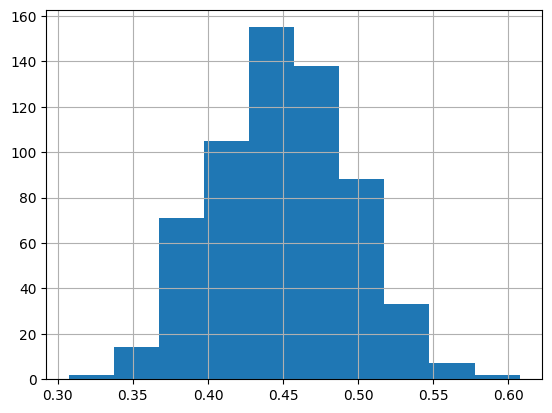

In [19]:
pd.Series(preds).hist()

<Axes: >

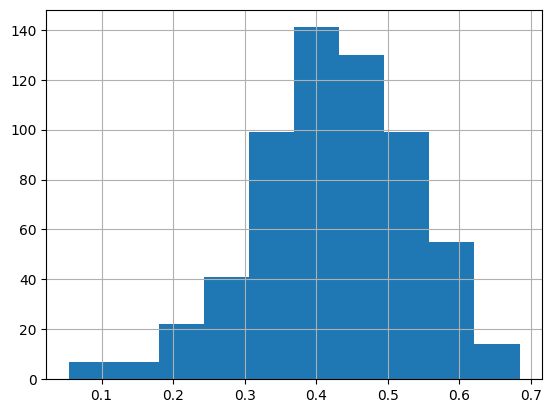

In [20]:
pd.Series(test_targets).hist()

Next, we plot the true vs predicted humour grade for our model.

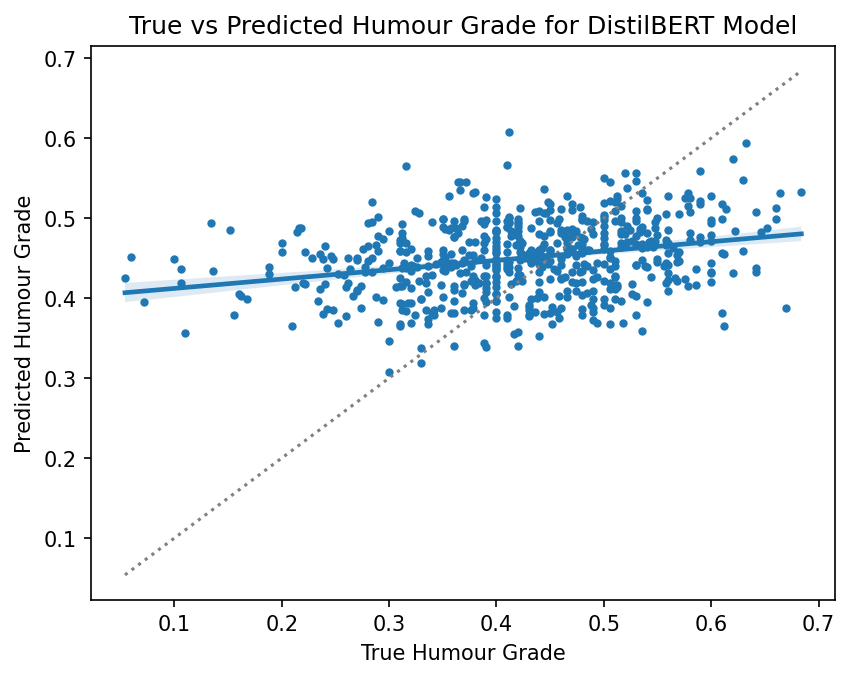

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
def get_pred_true_plot(preds, labels, title):
    limits = [labels.min(), labels.max()]
    fig, ax = plt.subplots()
    fig.set_dpi(150)
    ax.set_title(title)
    ax.scatter(labels, preds, marker='.')
    ax.plot(limits, limits, color="gray", linestyle=":")
    ax.set_xlabel('True Humour Grade')
    ax.set_ylabel('Predicted Humour Grade')
    sns.regplot(x=labels, y=preds, ax=ax, scatter_kws={"s": 5})
    plt.show()

get_pred_true_plot(preds, test_targets, 'True vs Predicted Humour Grade for DistilBERT Model')

Our regressor tends to smooth down the extreme rating values to make them closer to the mean.

# Feature Engineering & Data Augmentation

**Task 2: Preprocess the textual data with the Ekphrasis library following the standard pipeline https://github.com/cbaziotis/ekphrasis#text-pre-processing-pipeline. How does this affect the performance?**

*Hint*: You might not want to annotate terms in order to keep the same length of the input sentences (for this, do not use the parameter `annotate={"hashtag", "allcaps", "elongated", "repeated", 'emphasis', 'censored'}`).

In [22]:
!pip install -q ekphrasis
!pip3 install -q emoji==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [24]:
"""
Task 2

Begin
"""

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

# Create a text preprocessor using the standard pipeline
# Note: We set annotate=False and unpack_hashtags=False so that the length of the sentences remains unchanged.
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number'],
    fix_html=True,
    annotate=[],  # Do not annotate hashtags, allcaps, elongated, etc.
    unpack_hashtags=False,
    unpack_contractions=True,
    spell_correct_elong=True,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    emoticons=emoticons
)

"""
End Task 2
"""
new_train_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in train_examples_list]
new_dev_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in dev_examples_list]
new_test_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in test_examples_list]


Reading english - 1grams ...


In [25]:
print("Original Text:", train_examples_list[0])
print("Preprocessed Text:", new_train_examples_list[0])

Original Text: TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit...
Preprocessed Text: tennessee : we are the best state . nobody even comes close . * elevennessee walks into the room * tennessee : oh shit . . .


In [26]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(new_train_examples_list, train_targets_list)
dev_input_ids, dev_attention_masks, dev_targets = get_bert_inputs(new_dev_examples_list, dev_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(new_test_examples_list, test_targets_list)


# Prepare DataLoader
train_dataset = HumorDataset(train_input_ids, train_attention_masks, train_targets)
dev_dataset = HumorDataset(dev_input_ids, dev_attention_masks, dev_targets)
test_dataset = HumorDataset(test_input_ids, test_attention_masks, test_targets)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = BERTRegressionModel()
train_model(model, train_loader, dev_loader, device)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:42<00:00,  2.11s/it]


Train Loss: 0.0141, Val Loss: 0.0123


Epoch 2/5: 100%|██████████| 20/20 [00:44<00:00,  2.23s/it]


Train Loss: 0.0120, Val Loss: 0.0117


Epoch 3/5: 100%|██████████| 20/20 [00:44<00:00,  2.21s/it]


Train Loss: 0.0114, Val Loss: 0.0113


Epoch 4/5: 100%|██████████| 20/20 [00:44<00:00,  2.24s/it]


Train Loss: 0.0109, Val Loss: 0.0110


Epoch 5/5: 100%|██████████| 20/20 [00:44<00:00,  2.25s/it]


Train Loss: 0.0105, Val Loss: 0.0108


In [27]:
preds, test_targets = evaluate_model(model, test_loader, device)

Test loss: 0.0112
Test Mean Squared Error: 0.0114


Your results may be different depending on the implementation but typically special preprocessing does not drastically change the performance for this task.

**Task 3: Augment the training data twice by changing the original data via two methods from the Nlpaug (https://github.com/makcedward/nlpaug) library: (a) synonym replacement from WordNet; (b) deletion of random words. Comment on which method gives the best performance.**

*Hint*: Use the Synonym Augmenter and Random Word Augmenter (Delete word randomly) classes as follows:
```
aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(text)

aug = naw.RandomWordAug()
augmented_text = aug.augment(text)
```





For more examples check https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb

In [28]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 10.2 MB/s eta 0:00:00


In [29]:
# Get the data again to apply augmentation
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()

In [30]:
import nlpaug.augmenter.word as naw

"""
Task 3

Begin
"""

import nlpaug.augmenter.word as naw

# Create the augmenters
aug_syn = naw.SynonymAug(aug_src='wordnet')
aug_del = naw.RandomWordAug()

# Initialize lists for augmented training data
aug_train_examples_list = []
aug_train_targets_list = []

# For each training example, create two augmented versions:
# one with synonym replacement and one with random deletion.
for text, target in zip(train_examples_list, train_targets_list):
    # Append the original text and target
    aug_train_examples_list.append(text)
    aug_train_targets_list.append(target)

    # Augment using synonym replacement from WordNet
    try:
        aug_text_syn = aug_syn.augment(text)
    except Exception as e:
        aug_text_syn = text  # fallback in case of an error
    aug_train_examples_list.append(aug_text_syn)
    aug_train_targets_list.append(target)

    # Augment using random word deletion
    try:
        aug_text_del = aug_del.augment(text)
    except Exception as e:
        aug_text_del = text  # fallback in case of an error
    aug_train_examples_list.append(aug_text_del)
    aug_train_targets_list.append(target)

# Replace original training data with the augmented data
train_examples_list = aug_train_examples_list
train_targets_list = aug_train_targets_list


"""
End Task 3
"""


Streaming output truncated to the last 5000 lines.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_dat

'\nEnd Task 3\n'

In [31]:
print(train_examples_list[-2])
print(train_examples_list[4930])

How to keep the flies off the bride at an Italian wedding Keep a bucket of shit next to her
What do you call a witch who lives in the desert? A sand witch.


In [32]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
dev_input_ids, dev_attention_masks, dev_targets = get_bert_inputs(dev_examples_list, dev_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)

# Prepare DataLoader
train_dataset = HumorDataset(train_input_ids, train_attention_masks, train_targets)
dev_dataset = HumorDataset(dev_input_ids, dev_attention_masks, dev_targets)
test_dataset = HumorDataset(test_input_ids, test_attention_masks, test_targets)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


We have now augmented the original data twice:

In [33]:
print("Training examples before augmentation:")
print(len(train_df['text'].tolist()))
print("Training examples after augmentation:")
print(len(train_examples_list))

Training examples before augmentation:
4932
Training examples after augmentation:
14796


In [34]:
model = BERTRegressionModel()
train_model(model, train_loader, dev_loader, device)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 58/58 [02:16<00:00,  2.35s/it]


Train Loss: 0.0126, Val Loss: 0.0115


Epoch 2/5: 100%|██████████| 58/58 [02:15<00:00,  2.34s/it]


Train Loss: 0.0115, Val Loss: 0.0107


Epoch 3/5: 100%|██████████| 58/58 [02:15<00:00,  2.34s/it]


Train Loss: 0.0107, Val Loss: 0.0102


Epoch 4/5: 100%|██████████| 58/58 [02:15<00:00,  2.34s/it]


Train Loss: 0.0099, Val Loss: 0.0104


Epoch 5/5: 100%|██████████| 58/58 [02:15<00:00,  2.34s/it]


Train Loss: 0.0089, Val Loss: 0.0108


In [35]:
preds, test_targets = evaluate_model(model, test_loader, device)

Test loss: 0.0129
Test Mean Squared Error: 0.0134


Your results may be different depending on the implementation but typically there are no drastic differences between the augmentation setups.

# Ensembled BERT Model

In this section you will train and evaluate an **ensemble** of BERT models.

We define the hyperparameters, including the number of models we want to ensemble (RERUNS=3, i.e., 3 models).

**Task 4: Train three DistilBERT models, get their predictions on the test set, take the mean of those predictions and evaluate this ensembled prediction. Comment on the resulting performance.**

We create three models in a loop, set a new random seed before creating each of them (`set_random_seed(seed=random.randint(0, 500))`) and accumulate predictions per model in a list.

In [36]:
# Get the train data again to avoid any confusion
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)

# Prepare DataLoader
train_dataset = HumorDataset(train_input_ids, train_attention_masks, train_targets)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [37]:
RERUNS = 3
# We may save each model to a list
# trained_models = list()
# We save the predictions of each model to the list
all_model_preds = list()


for i in range(RERUNS):

  set_random_seed(seed=random.randint(0, 500))

  """
  Task 4

  Begin
  """

  # Create a new DistilBERT regression model
  model = BERTRegressionModel()

  # Train the model on the training data (using the dev_loader for validation)
  train_model(model, train_loader, dev_loader, device)

  # Get predictions on the test set
  preds_model, _ = evaluate_model(model, test_loader, device)

  # Append the predictions from this model to our list
  all_model_preds.append(preds_model)

  """
  End Task 4
  """



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


Train Loss: 0.0133, Val Loss: 0.0124


Epoch 2/5: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Train Loss: 0.0120, Val Loss: 0.0117


Epoch 3/5: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Train Loss: 0.0112, Val Loss: 0.0112


Epoch 4/5: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Train Loss: 0.0106, Val Loss: 0.0108


Epoch 5/5: 100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


Train Loss: 0.0101, Val Loss: 0.0106
Test loss: 0.0115
Test Mean Squared Error: 0.0119


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Train Loss: 0.0127, Val Loss: 0.0119


Epoch 2/5: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Train Loss: 0.0113, Val Loss: 0.0113


Epoch 3/5: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


Train Loss: 0.0109, Val Loss: 0.0110


Epoch 4/5: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


Train Loss: 0.0104, Val Loss: 0.0107


Epoch 5/5: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Train Loss: 0.0101, Val Loss: 0.0111
Test loss: 0.0131
Test Mean Squared Error: 0.0135


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Train Loss: 0.0129, Val Loss: 0.0120


Epoch 2/5: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


Train Loss: 0.0116, Val Loss: 0.0114


Epoch 3/5: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


Train Loss: 0.0111, Val Loss: 0.0108


Epoch 4/5: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


Train Loss: 0.0105, Val Loss: 0.0105


Epoch 5/5: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Train Loss: 0.0099, Val Loss: 0.0103
Test loss: 0.0122
Test Mean Squared Error: 0.0127


In [38]:
from sklearn.metrics import classification_report, mean_squared_error

mean_preds = np.mean(np.array(all_model_preds), axis=0)
ensemble_mse = mean_squared_error(test_targets, mean_preds)

print('Ensemble Test MSE : {:.4f}'.format(ensemble_mse))

Ensemble Test MSE : 0.0124


Your results may be different depending on the implementation but typically ensembling slightly improves the performance for this task.

# Multi-task Learning with BERT

**Task 5: Train a multi-task (MTL) model with the additional regression task of predicting the offense rating. The code to fetch these data is provided below. Comment on the resulting performance for the two models (single-task from task 1 and MTL).**

*Hint*: The MTL model will have two identical output layers (one for predicting humour rating, the other to predict offense rating). The layers need to be concatenated before applying the loss fuctions.

In [45]:
import gc
if 'model' in locals():
  del model
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [46]:
set_random_seed()

class BertMultitaskModel(nn.Module):
    """
    Task 5

    Begin
    """
    def __init__(self, pad_length=128):
        super(BertMultitaskModel, self).__init__()
        # Load the pre-trained DistilBERT model
        self.bert = DistilBertModel.from_pretrained(bert_model)
        # Global average pooling layer that takes the attention mask into account
        self.global_avg_pool = GlobalAveragePooling1DMasked()
        # Shared hidden layer
        self.hidden_layer = nn.Linear(self.bert.config.hidden_size, 16)
        # Sigmoid activation to keep outputs in [0,1] range
        self.activation = nn.Sigmoid()
        # Two separate output layers: one for humor, one for offense
        self.out_reg1 = nn.Linear(16, 1)
        self.out_reg2 = nn.Linear(16, 1)

    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # Shape: [batch_size, seq_length, hidden_size]

        # Apply global average pooling using the attention mask
        pooled_output = self.global_avg_pool(last_hidden_state, attention_mask)  # Shape: [batch_size, hidden_size]

        # Pass through the shared hidden layer
        hidden = self.hidden_layer(pooled_output)  # Shape: [batch_size, 16]

        # Compute the two regression outputs (with sigmoid to constrain values between 0 and 1)
        out_reg1 = self.activation(self.out_reg1(hidden))  # Humor rating output, Shape: [batch_size, 1]
        out_reg2 = self.activation(self.out_reg2(hidden))  # Offense rating output, Shape: [batch_size, 1]

        # Concatenate the outputs for both tasks (along dimension 1)
        return torch.cat([out_reg1, out_reg2], dim=1)

    """
    End Task 5
    """

In [41]:
model = BertMultitaskModel(pad_length=PAD_LENGTH).to(device)


In [42]:
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)

# Get the offense ratings for the second regression task (we normalise them as well)
train_targets2_list = (train_df['offense_rating']/5).tolist()
dev_targets2_list = (dev_df['offense_rating']/5).tolist()
test_targets2_list = (test_df['offense_rating']/5).tolist()

train_targets2 = np.array(train_targets2_list)
dev_targets2 = np.array(dev_targets2_list)
test_targets2 = np.array(test_targets2_list)

# Prepare DataLoader
train_targets_mix = [[i[0],i[1]] for i in zip(train_targets,train_targets2)]
train_dataset = HumorDataset(train_input_ids, train_attention_masks, train_targets_mix)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_targets_mix = [[i[0],i[1]] for i in zip(dev_targets,dev_targets2)]
dev_dataset = HumorDataset(dev_input_ids, dev_attention_masks, dev_targets_mix)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_targets_mix = [[i[0],i[1]] for i in zip(test_targets,test_targets2)]
test_dataset = HumorDataset(test_input_ids, test_attention_masks, test_targets_mix)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [43]:
# Instantiate model and train
train_model(model, train_loader, dev_loader, device)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


Train Loss: 0.0422, Val Loss: 0.0450


Epoch 2/5: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Train Loss: 0.0310, Val Loss: 0.0383


Epoch 3/5: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


Train Loss: 0.0276, Val Loss: 0.0339


Epoch 4/5: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Train Loss: 0.0219, Val Loss: 0.0239


Epoch 5/5: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Train Loss: 0.0176, Val Loss: 0.0213


In [44]:
preds, test_targets = evaluate_model(model, test_loader, device, multi_task=True)

Test loss: 0.0119
Test Mean Squared Error: 0.0122


Your results may be different depending on the implementation but typically MTL slightly improves the performance over the single-task model trained in similar conditions.